In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import scipy as sp

import os
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn import svm
from wordcloud import WordCloud, STOPWORDS
from __future__ import print_function
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.colheader_justify', 'left')
from IPython.display import display, HTML

# Crunchbase data

This set of data acquired through Crunchbase Pro subscription and manual download of CSVs.

Company founded between 2010 and 2016 in **Data and Analytics** category group: ```crunchbase_data/overall_company_list.csv```

Acquisition occurred between 2010 and 2016 in all categories: ```crunchbase_data/cb_acquisitions/*csv```

In [2]:
cb_data = pd.read_csv('crunchbase_data/overall_company_list.csv', index_col=0)
# cb_data = cb_data.drop_duplicates(subset=['Company Name', 'Website'])
cb_data = cb_data.drop_duplicates(subset=['Company Name'])
cb_data.year = cb_data.year.astype(int)
cb_data = cb_data.rename(columns={'year': 'Founded Year'})
print(cb_data.shape)
cb_data.head()

(8350, 28)


,Company Name,Category Groups,Headquarters Location,Description,Crunchbase Rank,Founded Date,Number of Articles,Total Equity Funding Amount,Total Funding Amount,Closed Date,...,IPO Date,Money Raised at IPO,Valuation at IPO,Stock Symbol,Stock Exchange,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Website,Founded Year
0,Krux,"Media and Entertainment, Data and Analytics, Sales and Marketing, Advertising","San Francisco, California, United States","Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.",35,2010-01-01,91,"$50,000,000","$50,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,7.4,9.4,9.6,http://www.krux.com,2010
1,Datadog,"Information Technology, Data and Analytics, Software","New York, New York, United States",Datadog is the essential monitoring service for dynamic cloud infrastructure.,374,2010-01-01,95,"$147,900,000","$147,900,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-0.5,-1.3,http://datadog.com,2010
2,Sumo Logic,"Data and Analytics, Software","Redwood City, California, United States","Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence.",407,2010-01-01,128,"$155,000,000","$155,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-1.2,0.6,http://www.sumologic.com,2010
3,Quid,"Information Technology, Data and Analytics, Software, Design","San Francisco, California, United States","Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.",709,2010-01-01,44,"$66,500,000","$66,500,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,2.5,http://quid.com,2010
4,Vicarious,"Media and Entertainment, Data and Analytics, Software, Video","San Francisco, California, United States","Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.",718,2010-01-01,33,"$72,000,000","$72,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,-1.4,http://vicarious.com,2010


In [3]:
acq_file_list = glob.glob('crunchbase_data/cb_acquisitions/*csv')
dfs = []
for f in acq_file_list:
    dfs.append(pd.read_csv(f))
acq_df = pd.concat(dfs, ignore_index=True)
acq_df = acq_df.drop_duplicates(subset=['Acquired Company Name'])

acq_df['Acquired Year'] = acq_df['Announced On Date'].apply(lambda x: int(x[-4:])) # extract year from date string

print(acq_df.shape)
acq_df.head()

(3729, 6)


,Transaction Name,Acquired Company Name,Acquiring Company Name,Announced On Date,Price,Acquired Year
0,Centric Health Corp. acquires CareRx,CareRx,Centric Health Corp.,09/22/2016,"$14,000,000",2016
1,Warburg Pincus acquires Ascentium Capital,Ascentium Capital,Warburg Pincus,10/04/2016,NaN,2016
2,Sharecare acquires BioLucid,BioLucid,Sharecare,09/29/2016,NaN,2016
3,Google acquires Api.ai,Api.ai,Google,09/19/2016,NaN,2016
4,Demand Media acquires The Other Art Fair,The Other Art Fair,Demand Media,09/16/2016,NaN,2016


In [4]:
# name_dup = cb_data[cb_data['Company Name'].duplicated(keep=False)].sort_values('Company Name')['Company Name']

In [5]:
# cb_data.loc[name_dup.index]

In [6]:
# cb_cname = cb_data['Company Name']
# acq_cname = acq_df['Acquired Company Name']
# print len(set(cb_cname))
# print len(set(acq_cname))
# print len(set(cb_cname.values) & set(acq_cname.values))

In [7]:
cb_data_merged = cb_data.merge(acq_df, how='left', left_on='Company Name', right_on='Acquired Company Name')

In [8]:
cb_data_merged.shape

(8350, 34)

# Acquisition over time

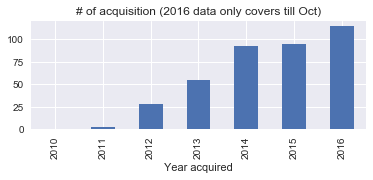

In [9]:
n_acq = cb_data_merged['Acquired Year'].value_counts(sort=False).sort_index()
n_acq.loc[[2010, 2011, 2012, 2013, 2014, 2015, 2016]].plot(kind='bar', figsize=(6,2))
plt.title('# of acquisition (2016 data only covers till Oct)')
plt.xlabel('Year acquired')

## Word cloud of company description over time

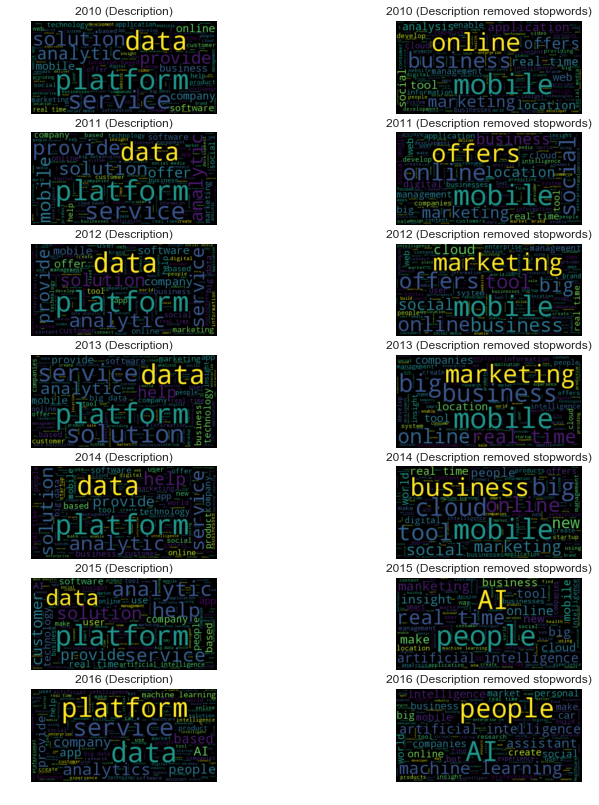

In [10]:
stopwords = set(STOPWORDS)
stopwords = stopwords.union({'product', 'technology', 'data', 'company', 'customer', 'analytic', 
                             'platform', 'analytics', 'provide', 'service', 'solution', 'provides', 'offer', 'help',
                            'software', 'solutions', 'app', 'based', 'services', 'user', 'offer', 'use', 'helps'})
plt.figure(figsize=(12,14))
i = 1
for y in range(2010, 2017):
    text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y].Description.values))

    wordcloud = WordCloud(max_font_size=60, random_state=19).generate(text)
    plt.subplot(7, 2, i)    
    i+=1
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(y) + ' (Description)')
    
    wordcloud = WordCloud(max_font_size=60, stopwords=stopwords, random_state=19).generate(text)
    plt.subplot(7, 2, i)    
    i+=1
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(y)+' (Description removed stopwords)')
    
#     text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y]['Categories'].values))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 4, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Categories tag)')
    
#     text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y]['Category Groups'].values))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 4, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Category Groups tag)')
    
    #plt.show()

In [11]:
# cb_data_merged['time_to_acq'] = cb_data_merged['Acquired Year'] - cb_data_merged['Founded Year']
# tmp_df = cb_data_merged[['Company Name', 'Founded Year', 'Acquired Year', 'time_to_acq']]
# tmp_df = tmp_df.dropna(axis=0)
# g = sns.factorplot(x="Founded Year", y="time_to_acq", data=tmp_df,
#                    size=6, kind="bar", palette="muted")
# g.despine(left=True)
# g.set_ylabels("survival probability")
# tmp_df

# See how many company names end with .ai

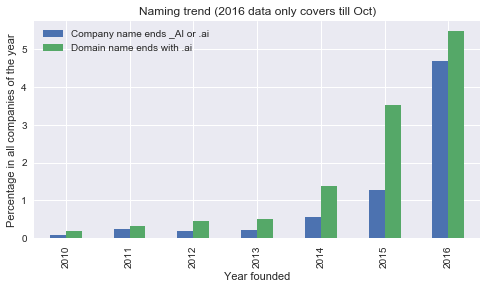

In [12]:
n_company = cb_data_merged['Founded Year'].value_counts().sort_index()
n_company.name = 'N company'

ai_names = cb_data_merged[cb_data_merged['Company Name'].str.endswith(' AI') | 
                          cb_data_merged['Company Name'].str.endswith('.ai')]['Founded Year'].value_counts(sort=False)
ai_names = ai_names / n_company *100
ai_names.name = 'Company name ends _AI or .ai'

ai_websites = cb_data_merged[cb_data_merged['Website'].str.endswith('.ai').fillna(False)]['Founded Year'].value_counts(sort=False)
ai_websites = ai_websites / n_company *100
ai_websites.name = 'Domain name ends with .ai'

io_websites = cb_data_merged[cb_data_merged['Website'].str.endswith('.io').fillna(False)]['Founded Year'].value_counts(sort=False)
io_websites = io_websites / n_company *100
io_websites.name = 'Domain name ends with .io'

#ai_df = pd.concat([ai_names, ai_websites, io_websites], axis=1)
ai_df = pd.concat([ai_names, ai_websites], axis=1)
ai_df.plot(kind='bar', figsize=(8,4))
plt.title('Naming trend (2016 data only covers till Oct)')
plt.xlabel('Year founded')
plt.ylabel('Percentage in all companies of the year')

# Comapny numbers vs locations

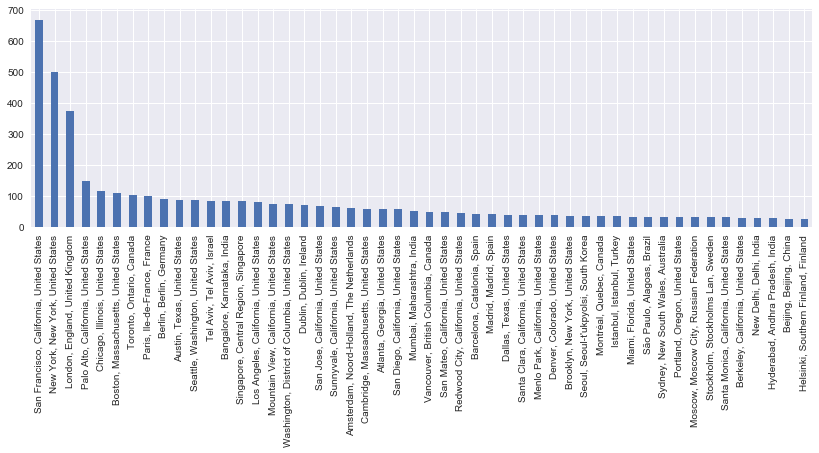

In [13]:
loc_list = cb_data_merged['Headquarters Location'].value_counts()[:50]
plt.figure(figsize=(14, 4))
loc_list.plot(kind='bar')

# Funding stats vs locations

In [14]:
# cover funding to float
print(cb_data_merged.shape)
funding = cb_data_merged['Total Funding Amount'].dropna().str.replace('$','').str.replace(',','').astype(float)
funding.name = 'funding'
cb_test = cb_data_merged.join(funding)
#cb_test['funding']

(8350, 34)


In [15]:
N_sub = 20
subset = cb_test[cb_test['Headquarters Location'].isin(loc_list.index[:N_sub])].copy()
subset['acquired'] = False
idx = subset['Acquired Year'].notnull()
subset.loc[idx, 'acquired'] = True
#subset[['acquired', 'Acquired Year', 'funding']]
# for i, r in subset.iterrows():
#     import re
#     pattern = re.compile('[\W_]+')
#     r['Headquarters Location'] = pattern.sub('', r['Headquarters Location']) 

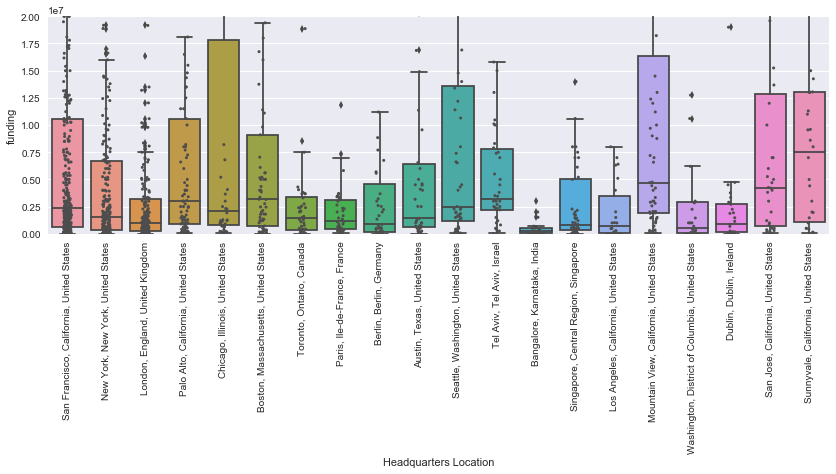

In [16]:
upper_limit = 20e6
plt.figure(figsize=(14, 4))
sns.boxplot(x="Headquarters Location", y="funding", data=subset, order=loc_list.index[:N_sub])
sns.stripplot(x="Headquarters Location", y="funding", data=subset, jitter=True, size=3, color=".3", linewidth=0,
             order=loc_list.index[:N_sub])
plt.ylim([0, upper_limit])
plt.xticks(rotation=90)
sns.despine(left=True)

In [17]:
# subset[subset['Headquarters Location'] == loc_list.index[19]].dropna(subset=['funding'])

# Compare funding stats similarity between different locations

In [18]:
locs = loc_list.index[:N_sub]
funding_sim_matrix = pd.DataFrame(columns=locs, index=locs, dtype=float)
#print(locs)
for i in locs:
    i_data = subset.loc[(subset['Headquarters Location'] == i) & (subset.funding<upper_limit)].funding.dropna().values
    for j in locs:
        if i==j:
            funding_sim_matrix.loc[i, j] = 0  # erase diagonal line
            continue
        j_data = subset.loc[(subset['Headquarters Location'] == j) & (subset.funding<upper_limit)].funding.dropna().values
        funding_sim_matrix.loc[i, j] = float(sp.stats.ks_2samp(i_data, j_data)[1])  # p-value from KS test

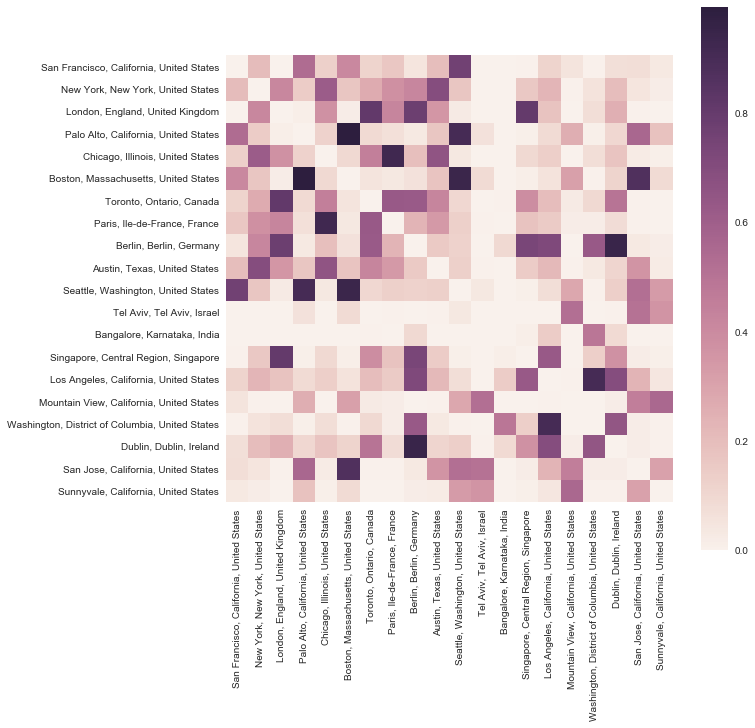

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(funding_sim_matrix, square=True)

Boston is similar to Seattle

Chicago is similar to Paris

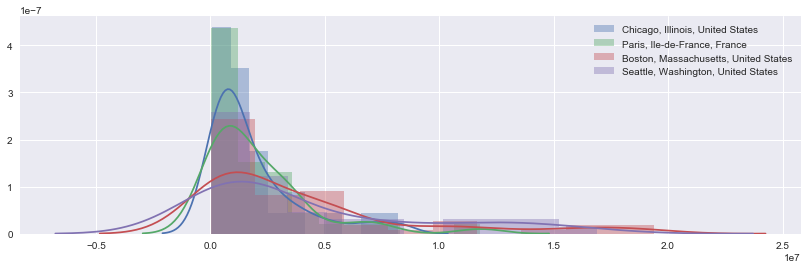

In [20]:
idx_i = [4, 7, 5, 10]

#plt.figure(figsize=(14,2*4))
plt.figure(figsize=(14,4))
i_ = 1
for i in idx_i:
    idx = (subset['Headquarters Location'] == loc_list.index[i]) & (subset['funding']<upper_limit)
    data = subset.loc[idx].funding.dropna().values
    #plt.subplot(len(idx_i),1, i_)
    i_ +=1
    sns.distplot(data, kde=True, bins=10, norm_hist=True)

#plt.xlim([0, 20e6])
plt.legend(locs[idx_i])

# Enrich description through a bit of scraping of google search results

See [scrape_google.py](scrape_google.py) for more, where I configured a search and fetch the text under the first result.

In [21]:
# company_list = list(cb_data_merged['Company Name'].values)
# company_list_file = 'company_list_CB.txt'
# with open(company_list_file, 'w') as f:
#     for c in company_list:
#         f.write("%s\n" % c) 

In [22]:
cb_data_merged['google_text'] = np.nan

In [23]:
for index, row in tqdm(cb_data_merged.iterrows(), total=cb_data_merged.shape[0]):
    c = row['Company Name']
    fname = os.path.join('google_text', '{}_CB.txt'.format(c))
    fname_backup = os.path.join('google_text', '{}_CB.txt'.format(str(hash(c))))
    actual_fname = None
    #print(fname)
    if os.path.exists(fname):
        actual_fname = fname
    if os.path.exists(fname_backup):
        actual_fname = fname_backup

    if actual_fname is not None:
        with open(actual_fname, 'r') as f:
            text = f.readline()
        cb_data_merged.loc[index, 'google_text'] = text
    else:
        #print('no text available for {}'.format(c))
        pass

100%|██████████| 8350/8350 [00:11<00:00, 739.81it/s]


In [24]:
print(len(cb_data_merged))
print(len(cb_data_merged[cb_data_merged.google_text.notnull()].google_text))

8350
8296


In [25]:
cb_data_merged.google_text.fillna('', inplace=True)

In [26]:
cb_data_merged['new_description'] = cb_data_merged['Description'] + ' ' + cb_data_merged['google_text']
cb_data_merged[['Company Name', 'new_description', 'Description', 'google_text']]

,Company Name,new_description,Description,google_text
0,Krux,"Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences. Krux helps companies deliver personalized commerce, media, and marketing experiences to the right people, in the right way, at the right time across all devices ...","Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.","Krux helps companies deliver personalized commerce, media, and marketing experiences to the right people, in the right way, at the right time across all devices ..."
1,Datadog,Datadog is the essential monitoring service for dynamic cloud infrastructure. Datadog is the essential monitoring service for dynamic cloud infrastructure.,Datadog is the essential monitoring service for dynamic cloud infrastructure.,Datadog is the essential monitoring service for dynamic cloud infrastructure.
2,Sumo Logic,"Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence. Sumo Logic is the next generation log management and analytics company that leverages Big Data for real-time IT insights. The company's cloud-based service ...","Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence.",Sumo Logic is the next generation log management and analytics company that leverages Big Data for real-time IT insights. The company's cloud-based service ...
3,Quid,"Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter. Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.","Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.","Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter."
4,Vicarious,"Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos. Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.","Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.","Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos."
5,"Alteryx, Inc.","Alteryx is the leader in self-service data analytics Alteryx, Inc. was formed in 2010 and is a leader in self-service data analytics. Alteryx Analytics provides analysts with the unique ability to easily prep, blend and ...",Alteryx is the leader in self-service data analytics,"Alteryx, Inc. was formed in 2010 and is a leader in self-service data analytics. Alteryx Analytics provides analysts with the unique ability to easily prep, blend and ..."
6,PlaceIQ,PlaceIQ provides location intelligence services that enable advertisers to reach mobile brand audiences for marketing activities. PlaceIQ provides location intelligence services that enable advertisers to reach mobile brand audiences for marketing activities.,PlaceIQ provides location intelligence services that enable advertisers to reach mobile brand audiences for marketing activities.,PlaceIQ provides location intelligence services that enable advertisers to reach mobile brand audiences for marketing activities.
7,Qubit,"Qubit gives marketers the tools to understand their visitors, and personalize their online presence to drive conversions in real time. Qubit gives marketers the tools to understand their visitors, and personalize their online presence to drive conversions in real time.","Qubit gives marketers the tools to understand their visitors, and personalize their online presence to drive conversions in real time.","Qubit

## Clean up and check

In [27]:
print(cb_data_merged.shape)
cb_data_merged.dropna(subset=['Description'], inplace=True)
# want to make sure a company has a description for further analysis
print(cb_data_merged.shape)
cb_data_merged.dropna(subset=['Company Name'], inplace=True)
# want to make sure a company has a description for further analysis
print(cb_data_merged.shape)

(8350, 36)
(8350, 36)
(8350, 36)


In [28]:
print(len(cb_data_merged['Company Name']) - len(cb_data_merged['Company Name'].unique()))

0


# Find similar startups based on company description

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(input='content', 
                    encoding='utf-8', decode_error='replace', strip_accents='unicode', 
                    lowercase=True, analyzer='word', stop_words='english', 
                    ngram_range=(1, 2), max_features = 10000, 
                    norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True,
                    max_df=1.0, min_df=1)

In [30]:
corpus = cb_data_merged['new_description']
v.fit(corpus)
X = v.transform(corpus)
X = X.todense()

corpus = cb_data_merged['Category Groups']
v.fit(corpus)
X_g = v.transform(corpus)
X_g = X_g.todense()
#X_g.shape

corpus = cb_data_merged['Categories']
v.fit(corpus)
X_c = v.transform(corpus)
X_c = X_c.todense()
#X_c.shape

X_new = np.concatenate((X, X_g, X_c), axis=1)
print(X_new.shape)

(8350, 16363)


In [31]:
def calc_sim(X, df, company_name_col):
    # calculate siimlarity based on tfidf vector of the company description
    try:
        X = X.todense() # originally it's a sparse matrix
    except:
        pass
    sim_dict = {}
    N_sim = 50
    batch_size = 200
    for i in tqdm(range(0,len(df),batch_size)):
        i1 = min(len(df), i+batch_size)
        xquery = X[i:i1] # BxD
        ds = -np.asarray(np.dot(X, xquery.T)) #NxD * DxB => NxB
        IX = np.argsort(ds, axis=0) # NxB
        for j in range(i1-i):
            sim_dict[df.loc[i+j, company_name_col]] = \
            [(df.loc[q, company_name_col], ds[q,j]) for q in list(IX[:N_sim,j])]
    return sim_dict

sim_dict_CB = calc_sim(X, cb_data_merged, 'Company Name')

100%|██████████| 42/42 [00:25<00:00,  1.78it/s]


In [32]:
def build_recommendation_table(company_name, sim_dict, df, company_name_col, description_col, label_col=None, N=6):
    counter = 0
    entry_list = []
    for i in sim_dict[company_name]:
        d = {'title': i[0], 'neg_inner_product': i[1], 
             'description': list(df[df[company_name_col]==i[0]][description_col])[0]}
        if label_col is not None:
            d['label'] = list(df[df[company_name_col]==i[0]][label_col])[0]
        entry_list.append(d)
    rec = pd.DataFrame(entry_list)
    #rec = rec.set_index('title')
    return rec.head(N)

In [33]:
c_list = ['Clarifai', 'Datadog', 'Insight Data Science', 'drive.ai']
for c in c_list:
    rec = build_recommendation_table(c, sim_dict_CB, cb_data_merged, 'Company Name', 'new_description', 'Category Groups')
    display(rec)

,description,label,neg_inner_product,title
0,Clarifai provides advanced image recognition systems for customers to detect near-duplicates and visual searches. Clarifai provides advanced image recognition systems for customers to detect near-duplicates and visual searches.,"Data and Analytics, Software, Internet Services",-1.000000,Clarifai
1,Revolutionary Image Recognition Fashion Platform Demere is focused on the development of image recognition technology solutions for the fashion industry. Demere provides its customers with fashion tips by ...,"Data and Analytics, Software",-0.313693,Demere
2,"Sales through image recognition technology SaveUp was a mobile application supporting sales through image recognition technology. After taking a photo of a cover of book, music album, movie or ...","Platforms, Apps, Data and Analytics, Software, Mobile",-0.283898,SaveUp.pl
3,"Shazura provides AI image recognition services without machine learning, revolutionizing visual search for all image-driven industries. Shazura's Image/Video Recognition technology, called the ""Google of Images"", has revolutionized and solved the pain points affecting visual content ...","Science and Engineering, Hardware, Data and Analytics, Software, Internet Services",-0.271028,Shazura
4,Endorsify is a social media agency leveraging machine learning algorithms to find the perfect micro-influencer to brand match Endorsify applies image recognition systems and machine learning models to the influencer marketing industry.,"Media and Entertainment, Data and Analytics, Software, Internet Services",-0.268490,Endorsify
5,Automatic image recognition powered by artificial intelligence. Starting with automated image recognition — MetaMind was founded to explore positive and impactful applications for artificial intelligence. We believe AI is only ...,"Science and Engineering, Hardware, Data and Analytics, Software",-0.265166,MetaMind


,description,label,neg_inner_product,title
0,Datadog is the essential monitoring service for dynamic cloud infrastructure. Datadog is the essential monitoring service for dynamic cloud infrastructure.,"Information Technology, Data and Analytics, Software",-1.000000,Datadog
1,CloudVertical offers tools for tracking and analyzing cloud infrastructure usage and costs. CloudVertical offers tools for tracking and analyzing cloud infrastructure usage and costs.,"Information Technology, Data and Analytics, Software, Internet Services",-0.347680,CloudVertical
2,NodeQuery is provides a lightweight and easy to use linux server monitoring service. NodeQuery is provides a lightweight and easy to use linux server monitoring service.,"Data and Analytics, Software, Internet Services",-0.264758,NodeQuery
3,Locatee is a provider of efficiency solutions for dynamic workspaces. Locatee is a provider of efficiency solutions for dynamic workspaces.,"Hardware, Data and Analytics",-0.200908,Locatee
4,Dynamic Components offers with SensorLink a solution to interconnect machines as well as extraction and monitoring of machine data. Dynamic Components offers with SensorLink a solution to interconnect machines as well as extraction and monitoring of machine data.,"Manufacturing, Science and Engineering, Data and Analytics, Internet Services",-0.198354,Dynamic Components
5,GOFACTORY provides an Industrial IoT service that drives intelligent action when uptime is essential. GOFACTORY provides an Industrial IoT service that drives intelligent action when uptime is essential.,"Data and Analytics, Software, Internet Services",-0.198224,"Go Factory, Inc."


,description,label,neg_inner_product,title
0,Insight Data Science is an intensive six week post-doctoral training fellowship bridging the gap between academia and data science. Insight Data Science is an intensive six week post-doctoral training fellowship bridging the gap between academia and data science.,"Data and Analytics, Education",-1.000000,Insight Data Science
1,"Data science bootcamp Become a data scientist in 9 weeks. BayesCamp is a nine week, onsite bootcamp where the fundamentals of data science are taught through hands-on ...","Data and Analytics, Education",-0.340289,BayesCamp
2,Bridging the gap between ideas and technology Awaken the data scientists in you. Hoonio brings your next ideas to become live. Design your own data experiment with us today! ADVERTISE ON ...,"Media and Entertainment, Data and Analytics, Events, Education, Internet Services, Mobile",-0.287773,Hoonio
3,We offer full cycle custom software development and R&D for non-standard and science intensive tasks. We offer full cycle custom software development and R&D for non-standard and science intensive tasks.,"Science and Engineering, Hardware, Data and Analytics, Software",-0.269670,Ocutri
4,"Hands-on Data Science Courses, Projects, & Content District Data Labs is a data science company. They teach data science concepts via their courses and workshops, they work on data science projects via their ...",Data and Analytics,-0.223553,District Data Labs
5,Antedote is a market research consultancy firm that offers technology-enabled actionable solutions. Antidote is accelerating the breakthroughs of new treatments by bridging the gap between medical research and the people who need them.,"Data and Analytics, Design",-0.208371,Antedote


,description,label,neg_inner_product,title
0,Self-driving cars for all. Deep learning company founded by Stanford AI lab alumni Drive.ai creates AI software for autonomous vehicles.,"Science and Engineering, Hardware, Data and Analytics, Software, Transportation",-1.000000,drive.ai
1,A new vision for a self-describing world Deep learning training data for autonomous vehicles Unfollow.,"Data and Analytics, Software",-0.401861,TheWhollySee
2,"AdasWorks develops artificial intelligence-based software for self-driving cars to make automated driving safe and affordable. Almotive, formerly AdasWorks, develops artificial intelligence-based software for self-driving cars to make automated driving safe and affordable. Their dedicated ...","Science and Engineering, Hardware, Information Technology, Data and Analytics, Software, Transportation, Internet Services, Design",-0.345609,AdasWorks
3,AI driven programs will become the standard against which business automation performance will be measured. And we are leading the way. Movyl is using Artificial Intelligence to advance social media marketing. AI is the technology poised to disrupt a wide variety of sectors. While self-driving cars are ...,"Science and Engineering, Media and Entertainment, Data and Analytics, Software, Sales and Marketing, Internet Services",-0.293830,Movyl
4,Novel sensors with embedded AI for autonomous vehicles and robotics. Machines With Vision develops and distributes embedded sensors to its clients. It develops embedded A.I. systems for autonomous vehicles and robotics and is ...,"Science and Engineering, Hardware, Data and Analytics, Software, Transportation",-0.265173,Machines With Vision
5,BestMile is a cloud-based company offering a fleet optimization platform for autonomous vehicles BestMile is a cloud-based company offering a fleet optimization platform for autonomous vehicles.,"Data and Analytics, Software, Transportation, Internet Services, Mobile",-0.237481,BestMile


# User favorites based recommendation

In [34]:
name_to_index = pd.Series(cb_data_merged.index, index=cb_data_merged['Company Name'].values).to_dict()

In [35]:
users = dict()

users['user1'] = ['Clarifai', 'Krux']  # images and marketing
users['user2'] = ['Insight Data Science', 'H2O.ai']  # bootcamp and platform/marketplace

num_recommendations = 10

for u in users.keys():
    fav_ix = [name_to_index[n] for n in users[u]]
    
    y = np.zeros(X_new.shape[0])
    for ix in fav_ix: 
        y[ix] = 1 # label positive samples
    
    clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=0.1)
    clf.fit(X_new,y)
    s = clf.decision_function(X_new)
    
    sortix = list(np.argsort(-s))
    # remove favs
    for f in fav_ix:
        sortix.remove(f)
    sortix = sortix[:min(num_recommendations, len(sortix))]
    users[u] = (users[u], cb_data_merged.loc[sortix][['Company Name', 'new_description', 'Crunchbase Rank']])

In [36]:
for u in users.keys():
    print('Users favorites: ', users[u][0])
    display(users[u][1])

Users favorites:  ['Insight Data Science', 'H2O.ai']


,Company Name,new_description,Crunchbase Rank
4386,BayesCamp,"Data science bootcamp Become a data scientist in 9 weeks. BayesCamp is a nine week, onsite bootcamp where the fundamentals of data science are taught through hands-on ...",NaN
3830,DataCamp,DataCamp is a young team of data analytics enthusiasts that provide free interactive data science and statistics education to the world. DataCamp is a young team of data analytics enthusiasts that provide free interactive data science and statistics education to the world.,"7,246"
5444,Algorithmia,"Algorithmia is an open marketplace for algorithms, enabling developers to create tomorrows smart applications today. Algorithmia is an open marketplace for algorithms, enabling developers to create tomorrows smart applications today.","3,736"
4646,Upswing,"Providing a highly flexible and personalized experience to learners and coaches. Upswing is redefining what it means to support student success. We partner with colleges to provide an easy-to-use virtual learning center for students, and ...","65,784"
6996,Tarefa.co,"Tarefa is Quora+Google for maths Tarefa.co the is academic support platform that is revolutionizing learning math in Latin America, connecting students unable to solve math questions with ...",NaN
7384,perchbox,"Intelligent, could based learning strategies. Update. Founded: 2015; Contact: info@perchbox.com; Employees: 1 - 10 | None found in Crunchbase. Click/Touch UPDATE above to add Details for perchbox ...",NaN
6994,GradeEdge,We bring transparency to education! Click/Touch UPDATE above to add Details for GradeEdge. ADVERTISE ON CRUNCHBASE · Announcing Crunchbase Enterprise. Crunchbase Enterprise ...,NaN
2290,Panorama Education,Panorama Education is bringing the power of data to education through a SaaS platform used by hundreds of school districts across the US. Panorama Education is bringing the power of data to education through a SaaS platform used by hundreds of school districts across the US.,"2,321"
3245,Learnmetrics,"Learnmetrics are a team of Educators, Academics, Technologists, and Designers who are committed to improving educational outcomes. Learnmetrics are a team of Educators, Academics, Technologists, and Designers who are committed to improving educational outcomes.","8,916"
2447,Schoolrunner,"Schoolrunner is a student data system that allows educators to track academics, attendance, behavior, and standards. Schoolrunner is a student data system that allows educators to track academics, attendance, behavior, and standards.","23,060"


Users favorites:  ['Clarifai', 'Krux']


,Company Name,new_description,Crunchbase Rank
7641,JustVisual,"JustVisual is a leading visual search and image recognition technology company. JustVisual has developed a unique, first of its kind, 3D object recognition engine to bring high-accuracy imaging into the world of search engines.","39,095"
2288,Slyce,"Slyce is a visual search and image recognition technology provider for retailers and brands. Slyce is a visual search and image recognition technology provider for retailers and brands. ... Slyce’s visual search technology can be used by retailers, brands, and publishers to allow shoppers to transact at the moment of inspiration. ... Slyce was founded in 2012 by Cameron Chell ...","2,056"
1936,Kuznech,"KUZNECH develops technology for in-image advertising, e-commerce and social communications. KUZNECH is a company that specializes in turning today's data into tomorrow's innovation by neural networks training.","25,162"
2385,Shazura,"Shazura provides AI image recognition services without machine learning, revolutionizing visual search for all image-driven industries. Shazura's Image/Video Recognition technology, called the ""Google of Images"", has revolutionized and solved the pain points affecting visual content ...","10,639"
2501,ZAPR,"TV to Mobile Retargeting | Media Consumption Repository ZAPR, is one of the world's first media consumption repositories and cross-targeting platforms. ZAPR's technology platform auto-detects comprehensively all ...","37,394"
1880,Ezakus,"Ezakus invent Pretargeting, best way to find your next customer Ezakus invent Pretargeting, best way to find your next customer.","19,631"
2339,CloudSight Inc.,CloudSight's mission is to become the global leader in image captioning and understanding. CloudSight's mission is to become the global leader in image captioning and understanding. Our aim is to deliver the most superior and state-of-the-art solution ...,"5,651"
4527,Fringefy,"Fringefy develops a visual search engine that helps people discover local content and services in the outdoor, urban environment Fringefy develops a visual search engine that helps people discover local content and services in the outdoor, urban environment.","35,538"
3404,ViSenze,ViSenze simplifies the visual web through artificial intelligence. ViSenze simplifies the visual web through artificial intelligence.,355
296,WeatherAlpha,"WeatherAlpha is a company that provides weather-driven business solutions, helping companies use the weather to their advantage. WeatherAlpha is a company that provides weather-driven business solutions, helping companies use the weather to their advantage.",NaN


# Recap of the walkthrough

* data exploration and manipulation in pandas
* statistics tests, measure of distribution similarity
* data visulaization with matplotlib and seaborn
* basic web scraping, parsing and text manipulation
* text representation with TDIDF
* recommendation based on vector similarity
* recommendation based on classification with user favorites

## Future work

* text representation with word2vec style encoding
* unsurprised clustering
* user network based recommendation
* recommendation of cross-site content (crunchbase, kickstarter, indieggoo, angellist, amazon launchpad)
* funding prediction (amount, timeline, source) based on company description and market